**This is the second version of the Scatterplot notebook, adapted to deal with five possible sources of Match Sketches: MegaGenome, TMBD, HMP, PathoMAP, and MetaSUB.**

### Distance & ID Load

In [1]:
%pylab inline
import umap

Populating the interactive namespace from numpy and matplotlib


In [2]:
#We load the distance matrix, which was generated in a phyllip format. Each row has the name of a sample and then the
#distances to all of the samplea above it in the file.
phy=open("MashTriangle/combinedDistances.phyllip","r")

#There are a total of 8220 samples for now (this can be seen in the first line of the phyllip file).
distances=np.zeros((8220,8220))
#We'll save the sample ids in a list and the distances in distances.
ids=[]

#We'll need a counter to fill the distance matrix.
i=-2
for line in phy:
#At the beggining of each line we increase the counter by 1.
    i+=1
#The first line of the file contains only the total number of samples so we ignore it (when we read the first line,
#i=-1).
    if i<0:
        continue
#The second line has just the id of the first samples. We simply save the id and that's it.
    if i==1:
        line=line.strip("\n").split("\t")
        ids.append(line[0].split(".gz")[0].split("/")[1])
        continue
    
#The rest of the lines have distances. In particular the nth id has n-1 distances (for the n-1 samples above it). 
#First we get the id.
    line=line.strip("\n").split("\t")
    ids.append(line[0].split(".gz")[0].split("/")[1])
    #continue
#Then we add the n-1 distances to the nth line and the nth column (the distance matrix is symmetrical).
    dist=asarray([float(x) for x in line[1::]])
    distances[0:i,i]=dist
    distances[i,0:i]=dist
    
phy.close()

In [3]:
len(ids)

8220

#### If ID deduplication needs not be done omit the two cells below

In [4]:
#We might be interested in deduplicating the data, as some of the samples might be present in more than one
#database.

#For that we can look at the distance matrix and look for samples with mash distance of 0.

#We'll save the samples to be deleted in toDelete and their positions in the id list in PositionstoDelete.
SampletoDelete=[]
PositionstoDelete=[]

#Now we iterate over the distance matrix. 
for i in range(0,len(ids)):
    for j in range(i,len(ids)):
#If a given pair of samples have a mash distance of 0, we add the id and position of the second one in the 
#corresponding lists for deletion.
        if i!=j and distances[i,j]==0:
            SampletoDelete.append(ids[j])
            PositionstoDelete.append(j)

In [5]:
#We delete the ids of the duplicated from ids.
for sample in SampletoDelete:
    ids.remove(str(sample))

#We remove the row and columns of the duplicated ids from the distance matrix.
distances=np.delete(distances,PositionstoDelete,axis=0)
distances=np.delete(distances,PositionstoDelete,axis=1)

In [6]:
#Now we associate each sample with its main project of origin. This can be MegaGenome, HMP, TMDB, PathoMAP or MetaSUB.

#We'll save the project name per sample in col and the number of the project per sample (see below) in numCol.
col=[]
numCol=[]
#We'll arbitrarily assign an integer id to each main project and save the association in colDict.
colDict={"MegaGenome":2,"HMP":5,"TMDB":10,"PathoMAP":15,"MetaSUB":20}

#We also need the ids split between projects to get their keywords for the hierarchy (see below), so we'll also generate 
#an id list of each project.
MegaGenomeids=[]
HMPids=[]
TMDBids=[]
PathoMAPids=[]
MetaSUBids=[]

#Now we go over the ids list.
for i in range(len(ids)):
#The ids from each project have a particuar naming system which helps us identify them. We edit the ids elements
#so that we only have the sample name (with no extensions) and add the id/main project name to numCol/col.

#The ids from MegaGenome are numbers, with or without a fastq extension.
    if "fastq" in ids[i] or ids[i].isdigit():
        numCol.append(colDict["MegaGenome"])
        col.append("MegaGenome")
        temp=ids[i].replace("_1.fastq","")
        ids[i]=temp
        MegaGenomeids.append(ids[i])
#The ids from MetaSUB either being with haib or sossowski and might have a fq extension.
    elif "haib" in ids[i] or "sossowski" in ids[i]:
        numCol.append(colDict["MetaSUB"])
        col.append("MetaSUB")
        temp=ids[i].replace(".R1.fq","")
        ids[i]=temp
        MetaSUBids.append(ids[i])
#The HMP ids begin have HMP¨in their ids.
    elif "HMP" in ids[i]:
        numCol.append(colDict["HMP"])
        col.append("HMP")
        HMPids.append(ids[i])
#The PathoMAP ids have PATHOMAP in their ids.
    elif "PATHOMAP" in ids[i]:
        numCol.append(colDict["PathoMAP"])
        col.append("PathoMAP")
        PathoMAPids.append(ids[i])
#Finally, the TMBD ids have some identifier with RR in its id (e.g.: SRR or ERR).
    elif "RR" in ids[i]:
        numCol.append(colDict["TMDB"])
        col.append("TMDB")
        temp=ids[i].replace(".R1.fq","")
        ids[i]=temp
        TMDBids.append(ids[i])
    else:
        print(ids[i])

## Hiearchy Metadata Load

Now we proceed to load the metadata associated to the sample hierarchy. The hierarchy is a basic classification scheme of the samples which helps us discriminate them better, based on their specific object of study. The current hiearchy is shown below. Sequencer and Technique are additional classifications, which can be applied at any point of the hierarchy.

![Sequencer and Technique are additional classification, which can be applied at any point of the hierarchy](Hierarchy.png "Project Hierarchy")

There are 3 levels in the hierarchy. Each level has one or more classifications, and within each classification (with the exception of those in level 1 and the environmental classifications of level two) a sample has a specific category:

* Level 1 data can be environmental (i.e.: come from an abiotic source) or organismal (i.e.: come from an organism).
* Level 2:
    * **Environmental** data can come from an ecological ("natural") source or come from an anthropogenic ("man made") source.
    * **Organismal** comes from a given organism and/or a body part.
* Level 3:
    * **Environmental** data can have a location and/or a specific source or biome of origin. Note that these two are not mutually exclusive, but rather possible properties of both anthropogenic or ecological samples.
    * **Organismal** data from a given organism can be associated to a given body part. Note that it might also be possible to map a given body part to a sample without knowing the organism it came from (due to insufficient metadata), so that's why body part is part of levels 2 and 3 of the hierarchy.

### Hierarchy Load

First thing we need to do is load the hierarchy itself, located in the a set of csv files. There is one per possible classification in the hierarchy, with the exception of Biome/Source, for which there is one csv for anthropogenic sources and one for ecological sources/biomes (this is done for easier modification of the categories if needed). Then we load the info from each databatase and classify the samples as best as we can based on their metadata. 


Each csv contains multiple columns. The first one contains the specific category (i.e.: specific organism) for each classification, and the rest all of the metadata values which are grouped under that category.

In [7]:
#Most of the classifications in the hierarchy have their own csv files with its internal categories. All csv files 
#are located in the same folder (HierarchyFiles). So we'll cycle through the files and load all classifications.

#The exceptions to this are the first level classifications, as they are their own categories, so we have a single file
#for both of them, and the level two classifications for environmental samples, as they are mutually exclusive, so
#they are inferred from the third level categories.
import os
folder="HierarchyFiles_Extended"
#folder="HierarchyFiles"

#We'll save the info of the hierarchy in a dictionary. The keys will be the classifications (e.g.: 
#Organism) and the values will be dictionaries of categories as keys and lists of values associated to the categories 
#as values. 

#We need not organize the hierarchy right now. This can be done when associating classifications to each sample.
allHierarchy={}
for file in os.listdir(folder):
    classificationName=file.replace(".csv","")
    classificationFile=open(folder+"/"+file,"r",encoding="utf-8")

#For each classification we open the file, and look at the categories.
    categoryDict={}
    for line in classificationFile:
        
#For each category we get its name and then save its values in a column. We save then the name and list of values as 
#key and value pairs in the classification's dictionary.
        line=line.strip("\n").split(";")
        thisValues=[]
        for value in line[1::]:
            if value!="" and value!=" ":
                thisValues.append(value)
        categoryDict[line[0]]=thisValues
    classificationFile.close()
#We save the classification dictionary of categories in the classification dictionary.
    allHierarchy[classificationName]=categoryDict
    classificationFile.close()

### Project Metadata Load & Hierarchy Assignment

Now we proceed to load the metadata from each dataset and associate to each sample its place and values in the hierarchy. We'll do it sepparately for each project.

#### MegaGenome

For MegaGenome we have a set of Old Keywords from the previous batches of data, so we need to look at the new ones to classify them. To do that we load all keywords and then check those which are not in the original file.

This first entails getting the bioprojects of all projects and associating keywords with them. We do that first.

In [8]:
#MGids will save the ids of the sample (SRAs), projects will save the bioproject identifiers (PJRNA). We'll first load
#and then order based on the distance matrix.
MGids=[]
projects=[]

#The ids and corresponding project are saved in three files (based on the three batches of samples from MegaGenome).
#We load all three and add to ids and projects.

MGOne=open("Proj_UIDFiles/Proj_UID.csv","r")

for line in MGOne:
    line=line.strip("\n").split(";")
    MGids.append(line[0])
    projects.append(line[1])

MGOne.close()

MGTwo=open("Proj_UIDFiles/Proj_UIDBatch2.csv","r")

for line in MGTwo:
    line=line.strip("\n").split(";")
    MGids.append(line[0])
    projects.append(line[1])

MGTwo.close()

MGThree=open("Proj_UIDFiles/Proj_UIDBatch3.csv","r")

for line in MGThree:
    line=line.strip("\n").split(";")
    MGids.append(line[0])
    projects.append(line[1])

MGThree.close()

In [9]:
#Now we move on to load the keywords for the bioprojects which have them. In general almost
#all bioprojects have keywords.

#For keywords the file Papers-Grid_Min.csv (custom made based on the Airtable data) contains the title of the
#project (or paper if there's a paper), the bioproject identifier and the keywords from airtable.
fpapers=open("AirtableFiles/Papers-Grid_Min.csv","r",encoding="utf-8")

#We'll save the keywords per project in keywords and the projects corresponding to each set of keywords in
#ProjforKeywords. Note that we're mapping projects to keywords, not samples to keywords. Also, since 
#Papers-Grid_Min.csv was downloaded from Airtable, the order of the projects is not necessarily the same as 
#in the list projects generated above (that's why we need another list).
ProjforKeywords=[]
keywords=[]

for line in fpapers:
#We use the PRJNA in the project id as a separator and get the list of keywords from every project.
    if "PRJNA" in line:
        line=line.strip("\n").split('PRJNA')
        projectID="PRJNA"+line[1].split(",")[0].split(";")[0].split(".pdf")[0].split(")")[0].replace(" ","")
#Since we're only interested in the keywords of the projects whose samples have Mash distances, we filter
#the projects and get the keywords of those which are present in Proj_UID.csv or Proj_UIDBatch2.csv.
        if projectID in projects:
            ProjforKeywords.append(projectID)
            Prelkeywords=line[1].split(",")[1::]
            Realkeywords=[]
            for i in Prelkeywords:
                if i=="":
                    continue
                else:
#keywords are added in lowercase.
                    Realkeywords.append(i.lower())
            keywords.append(Realkeywords)
fpapers.close()

**If all keywords have already been included in the hierarchy skips the cell below.**

In [12]:
#With the loaded keywords from all batches of data, we can determine the new keywords. First we load the old keyword
#file.

OldKeywords=[]
OldK=open("KeywordConsolidation_Docs/Oldkeywords.txt","r")

for line in OldK:
    OldKeywords.append(line.strip("\n"))

OldK.close()

#Now we compare with the keywords we have now and save the new ones in another file.

NewK=open("KeywordConsolidation_Docs/Newkeywords.txt","w")
for kList in keywords:
    for k in kList:
        if k not in OldKeywords:
            NewK.write(k+"\n")
NewK.close()

FileNotFoundError: [Errno 2] No such file or directory: 'KeywordConsolidation_Docs/Oldkeywords.txt'

In [10]:
#We'll also load the title of the papers for those bioprojects which have them.

#We use the same file as for keywords, but load in a different part of the code just to make sure we do it correctly
#(given the noisy format of that file).
fpapers=open("AirtableFiles/Papers-Grid_Min.csv","r",encoding="utf-8")

#We'll save the paper names in Papers and the biorpojects with papers in ProperPaper.
Papers=[]
ProperPaper=[]

for line in fpapers:
#We split in a similar way as when looking for keywords.
    if "PRJNA" in line:
        line=line.strip("\n").split('PRJNA')
#We get the get the project id and the paper title and save them.
        projectID="PRJNA"+line[1].split(",")[0].split(";")[0].split(".pdf")[0].split(")")[0].replace(" ","")
        if projectID in projects:
            Papers.append(line[0])
            ProperPaper.append(projectID)
fpapers.close()

In [11]:
#Now we assign bioprojects to the hierarchy (as its easier to do it first that way).

#First we generated a deduplicated set of bioprojects.
DeDupProjects=list(set(projects))

#We'll save the resuls in a dictionary, with the values being the projects ids and the values being dictionaries
#with the categories per classification (see below).
BioProjtoHierarchy={}


for bioproject in DeDupProjects:

#We define a dictionary for saving the assignment of each project.
    classificationDict={}

#It might be the case that we have a mash distance for a project but no metadata in Airtable. This try-except here
#checks if that's the case and omits those bioprojects in which we have the issue.
    try:
        test=keywords[ProjforKeywords.index(bioproject)]
    except:
        print(bioproject)
        continue

#We cycle through all possible classifications and categories within them.
    for classification,categories in allHierarchy.items():
        categoriesinProj=[]
        for category,values in categories.items():
#IF a given keyword is a value for a category in a classification, we add the category to the list categoriesinProj.
            for keyword in keywords[ProjforKeywords.index(bioproject)]:
                if keyword in values:
                    categoriesinProj.append(category)
#If the project is associated to a paper, we also check the paper's title and add categories if we find their values
#therein.
            if bioproject in ProperPaper:
                for value in values:
                    if value in Papers[ProperPaper.index(bioproject)].lower():
                         categoriesinProj.append(category)
#It might be the case that many keywords from a project are values of the same cateogry, so we deduplicate the
#category list here.
        if len(categoriesinProj)!=0:
            classificationDict[classification]=list(set(categoriesinProj))
    
#If we did not find directly any values associated to the first level classifications (Overall is the name of that
#csv file), then we assign one based on the second and third level classifications.
    if "Overall" not in classificationDict.keys():
        if "Organism" in classificationDict.keys() or "BodyPart" in classificationDict.keys():
            classificationDict["Overall"]=["Organismal"]
        elif "Source_Surface" in classificationDict.keys() or "Source_Biome" in classificationDict.keys() or "Location" in classificationDict.keys():
            classificationDict["Overall"]=["Environmental"]
            
    BioProjtoHierarchy[bioproject]=classificationDict

PRJNA666900


In [12]:
#Finally, we can associated the samples with their hierarchy assignment using the bioproject information.
#We'll save the assignments of all projects (not only MegaGenome) in sampletoHierarchy. It will work just as 
#BioProjtoHierarchy.

sampletoHierarchy={}

#We cycle through the MegaGenome ids (saved in MGids), get their corresponding bioproject, and save their hierarchy
#assignment.
for ID in MGids:
    try:
        sampletoHierarchy[ID]=BioProjtoHierarchy[projects[MGids.index(ID)]]
    except:
         sampletoHierarchy[ID]={"Overall":["No Metadata"]}

In [13]:
len(sampletoHierarchy)

2141

#### TMDB

For TMDB we have a csv file which maps each sample to its metadata, so it's much easier to work with as compared to megaGenome. We also have project titles which might come in handy.

In [14]:
#First we load the metadata. The file has a lot of information, but we only need certain columns for the hierarchy
#assignment. 

#Given that we can readily associated metadata to each sample using this file, we'll assign as we read.

tmdbFile=open("ProjectMetadata/TMDB_metadata.csv","r")

for line in tmdbFile:
#We extract the lines we need. They contain multiple information, inclusing the project Id, material, 
#project name, sequencing platform, location, and other sample source info.
    line=line.strip("\n").split(",")
    TMDBID=line[0].replace(" ","")
    
#If the sample doesn't have a mash distance we skip it.
    if TMDBID not in ids:
        continue

#We save the sample info in sampleInfo.

#Position 5 of the metadata contains the project material, while 13 contains the biome.
    sampleInfo=[line[4].lower(),line[13].lower()]
#Positions 15 on contain more specific info related to the material and biome.
    sampleInfo.extend(line[15::])
    while "" in sampleInfo:
        sampleInfo.remove("")
#The title of the project is in position 14. We save that apart to look for values in it.
    sampleTitle=line[14].lower()

#The process after this is basically the same as for MegaGenome. The sampleInfo can be seen as the keywords of
#that sample.

    classificationDict={}
    for classification,categories in allHierarchy.items():
        categoriesinSample=[]
        for category,values in categories.items():
#If a given keyword is a value for a category in a classification, we add the category to the list categoriesinSample.
#We also check the project title for more keywords.
            for keyword in sampleInfo:
                if keyword in values:
                    categoriesinSample.append(category)
                for value in values:
                    if value in categoriesinSample or value in sampleTitle.lower():
                         categoriesinProj.append(category)
#It might be the case that many keywords from a project are values of the same cateogry, so we deduplicate the
#category list here.
        if len(categoriesinSample)!=0:
            classificationDict[classification]=list(set(categoriesinSample))
#If we did not find directly any values associated to the first level classifications (Overall is the name of that
#csv file), then we assign one based on the second and third level classifications.
    if "Overall" not in classificationDict.keys():
        if "Organism" in classificationDict.keys() or "BodyPart" in classificationDict.keys():
            classificationDict["Overall"]=["Organismal"]
        elif "Source_Surface" in classificationDict.keys() or "Source_Biome" in classificationDict.keys() or "Location" in classificationDict.keys():
            classificationDict["Overall"]=["Environmental"]
    sampletoHierarchy[TMDBID]=classificationDict

tmdbFile.close()

In [15]:
len(sampletoHierarchy)

3713

#### MetaSub

In [16]:
#The following one is MetaSub. The procedure will be very similar to the one for TMDB, but slighly more simple as 
#the data we need is much more localized in the metadata file.

#We load the file.
MSfile=open("ProjectMetadata/MetaSub_metadata.csv","r")


for line in MSfile:
#We extract the lines we need as we did before. 
    line=line.strip("\n").split(",")
    MSID=line[0].replace(" ","")
    
#If the sample doesn't have a mash distance we skip it.
    if MSID not in ids:
        continue

#We save the sample info in sampleInfo.

#Position 2 of the metadata contains the city, and positions 14, 24, and 42 the surface. 
    sampleInfo=[line[1].lower(),line[14].lower(),line[38].lower(),line[68].lower()]
    
#To avoid potential ambiguities we remove water as a potential sampleInfo.
    try:
        sampleInfo.remove("water")
    except:
        pass
#For this case the project names do not have titles from which we can get any interesting information.

#The process after this is basically the same as for MegaGenome. The sampleInfo can be seen as the keywords of
#that sample.
    classificationDict={}
    for classification,categories in allHierarchy.items():
        categoriesinSample=[]
        for category,values in categories.items():
#IF a given keyword is a value for a category in a classification, we add the category to the list categoriesinSample.
            for keyword in sampleInfo:
                if keyword in values:
                    categoriesinSample.append(category)
                for value in values:
                    if value in categoriesinSample:
                         categoriesinProj.append(category)
#It might be the case that many keywords from a project are values of the same cateogry, so we deduplicate the
#category list here.
        if len(categoriesinSample)!=0:
            classificationDict[classification]=list(set(categoriesinSample))
#If we did not find directly any values associated to the first level classifications (Overall is the name of that
#csv file), then we assign one based on the second and third level classifications.
    if "Overall" not in classificationDict.keys():
        if "Organism" in classificationDict.keys() or "BodyPart" in classificationDict.keys():
            classificationDict["Overall"]=["Organismal"]
        elif "Source_Surface" in classificationDict.keys() or "Source_Biome" in classificationDict.keys() or "Location" in classificationDict.keys():
            classificationDict["Overall"]=["Environmental"]
    sampletoHierarchy[MSID]=classificationDict
    
MSfile.close()

In [17]:
len(sampletoHierarchy)

5898

#### HMP

In [18]:
#Fourth one is HMP. Here there is even less metadata so it's even easier than for MetaSUB.

#First we load the metadata. The file has a lot of information, but we only need certain columns for the hierarchy
#assignment. 

#Given that we can readily associated metadata to each sample using this file, we'll assign as we read.

hmpFile=open("ProjectMetadata/HMP_metadata.csv","r")

for line in hmpFile:
#We extract the lines we need. T
    line=line.strip("\n").split(",")
    HMPID=line[0].replace(" ","")
    
#If the sample doesn't have a mash distance we skip it.
    if HMPID not in ids:
        continue

#We save the sample info in sampleInfo.

#Position 1 of the metadata contains the type of sequencing, and 9 the body part.
    sampleInfo=[line[1].lower(),line[9].lower()]
    while "" in sampleInfo:
        sampleInfo.remove("")
#The title of the project is in position . We save that apart to look for values in it.
    sampleTitle=line[8].lower()
    
#The process after this is basically the same as for MegaGenome. The sampleInfo can be seen as the keywords of
#that sample.

    classificationDict={}
    for classification,categories in allHierarchy.items():
        categoriesinSample=[]
        for category,values in categories.items():
#If a given keyword is a value for a category in a classification, we add the category to the list categoriesinSample.
#We also check the project title for more keywords.
            for keyword in sampleInfo:
                if keyword in values:
                    categoriesinSample.append(category)
                for value in values:
                    if value in categoriesinSample or value in sampleTitle.lower():
                         categoriesinProj.append(category)
#It might be the case that many keywords from a project are values of the same cateogry, so we deduplicate the
#category list here.
        if len(categoriesinSample)!=0:
            classificationDict[classification]=list(set(categoriesinSample))
            
#For the HMP dataset we know all samples are human, so we add that to the hierarchy assignment.    
        classificationDict["Organism"]=["Human"]
    
#If we did not find directly any values associated to the first level classifications (Overall is the name of that
#csv file), then we assign one based on the second and third level classifications.
    if "Overall" not in classificationDict.keys():
        if "Organism" in classificationDict.keys() or "BodyPart" in classificationDict.keys():
            classificationDict["Overall"]=["Organismal"]
        elif "Source_Surface" in classificationDict.keys() or "Source_Biome" in classificationDict.keys() or "Location" in classificationDict.keys():
            classificationDict["Overall"]=["Environmental"]
    print(classificationDict)
    sampletoHierarchy[HMPID]=classificationDict
    
hmpFile.close()

{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Hu

{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Blood Cell'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Blood Cell'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Blood Cell'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Nasopharynx'], 'Organism': ['Human

{'BodyPart': ['Oral-Tonsil'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Oral-Gingival'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Fecal'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Fecal'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Oral'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Fecal'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Oral-Gingival'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Oral-Tongue'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Oral'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Fecal'], 'Organism': ['Human'], 'Technique': ['Shotgun'], '

{'BodyPart': ['Oral'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Oral'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['External Naris'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Oral-Gingival'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['External Naris'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Vaginal'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Fecal'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Oral-Tongue'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['Oral-Gingival'], 'Organism': ['Human'], 'Technique': ['Shotgun'], 'Overall': ['Organismal']}
{'BodyPart': ['External Naris'], 'Organism': ['Human'], 'Tec

In [19]:
len(sampletoHierarchy)

6348

#### PathoMAP

In [20]:
#The last case is PathoMap. For PathoMAP there is really no metadata inside the file, but there might be in the future
#so we leave the code ready just in case.

#We only know for now thatr all samples are environmental and come from NYC so we can add that.

#We load the file.
PMfile=open("ProjectMetadata/PathoMAP_metadata.csv","r")


for line in PMfile:
#We extract the lines we need as we did before. 
    line=line.strip("\n").split(",")
    PMID=line[0].replace(" ","")
#If the sample doesn't have a mash distance we skip it.
    if PMID not in ids:
        continue
    sampletoHierarchy[PMID]={"Overall":["Environmental"],"Location":["NYC"]}

PMfile.close()

In [21]:
len(sampletoHierarchy)

7868

#### Ids with no Assignment

In [22]:
#Some of the ids from the projects might have no assignment yet. For order purposes they should be nonetheless
#added to sampletoHierarchy, at least with an empty dictionary.

for ID in ids:
    if ID not in sampletoHierarchy.keys() or len(sampletoHierarchy[ID])==0:
        #print(ID)
        sampletoHierarchy[ID]={"Overall":["No Metadata"]}

## Clustering Analyses

Now that the hierarchies are loaded and the samples assigned, we can move on to graph parts of the hierarchy as we
deem fit. For this, we'll first need to define what we want to graph. After that, a two-dimensional representation  based on mash distances can be generated with UMAP, and then clustering can be done with the mash distances with dbSCAN.

### Hierarchy Selection

First we generate code for selecting what to graph. The code allows for graphing specific classifications, for specific categories if necessary, and for specific datasets if necessary.

In [23]:
#The function generateCol will help us construct labels for plotting. It takes a list of classifications, categories,
#and/or datasets which want to be labelled. If one does not wish to label by one of those, then the list ["all"]
#must be passed as argument in the corresponding position.
def generateCol(selClassifications,selCategories,selDatasets):

#newClas, newCat and newDat save the labelling for classification, category and dataset, respectively.
    newClas=[]
    newCat=[]
    newDat=[]

#byClassification, byCategory and byDataSet are equal to 0 if we're not labelling based on classification, category
#or dataset, and 1 if we are.
    byClassification=0
    byCategory=0
    byDataSet=0

#First we check how we want to discriminate and set the associated by variables to 1.
    if selClassifications[0]!="all":
        byClassification=1
        
        if selCategories[0]!="all":
            byCategory=1
      

    if selDatasets[0]!="all":
        byDataSet=1
        
#The labelling itself is done id by ID, in the same order as ids appear in the ids list (and by extension in the
#distance matrix).
    for ID in ids:

#First we do the dataset labelling.
        if byDataSet==1:

#If the dataset of the sample is not one of the ones we want to label, then we simply label it as "Other". Since we
#are not interested in the classification or categories of that sample, as it does not belong to a dataset
#of interest, we simply label them as "Other" as well.
            if col[ids.index(ID)] not in selDatasets:
                newDat.append("Other")
                newCat.append("Other")
                newClas.append("Other")
                continue
#If it is part of the dataset of interest, we label the sample with the name of the dataset.
            else:
                newDat.append(col[ids.index(ID)])
#If datasets are not being used as a filtering criteria, we simply add the name of the dataset to newDat for all
#samples.
        else:
            newDat.append(col[ids.index(ID)])

#Nest we label by classification and category.
        if byClassification==1:

#Here we do an additional check of dataset labelling. If the sample is from "Other" (i.e.: not one of interest)
#dataset and we're labelling, using datasets, we simply label the classifications and categories as "Other" and 
#skip this part.
            if byDataSet==1 and newDat[-1]=="Other":
                newClas.append("Other")
                newCat.append("Other")
                continue

#The classifications of the sample are obtained from the key list of sampletoHierarchy.
            thisClassifications=[]
            for classification in sampletoHierarchy[ID].keys():
#If the classification is one of the ones we're interested in, it is added to thisClassifications.
                if classification in selClassifications:
                    thisClassifications.append(classification)
#If thisClassifications has a length of zero, then the classifications in the sample are not of interest, so we
#label it and its categories as "Other" and skip the rest.
            if len(thisClassifications)==0:
                newClas.append("Other")
                newCat.append("Other")
                continue
#If at least one classification of interest is associated to the sample, we join them withan underscore and add
#them to newClas.
            else:
                newClas.append("_".join(thisClassifications))
#Now we move on to the categories. We'll use categoriesperClass to store the relevant categories per class.
            categoriesperClass=[]
#For each relevant classification we get all the categories.
            for classification in thisClassifications:
#It's useful to check whether the classification is being filtered by some of its categories. We do that by checking if 
#at least one category in the classification is present in selCategories. If it is withSelCat is equal to 1, otherwise
#it's 0.
                withSelCat=0
                for cat in selCategories:
                    if cat in allHierarchy[classification]:
                        withSelCat=1
                        break
                thisCategories=[]
                categories=sampletoHierarchy[ID][classification]
#We look at each category. If we're labelling by category, and its contained in the interesting categories, we 
#add it to thisCategories. If we're not labelling by category we directly add it.
                for category in categories:
#If withSelCat is equal to 1, then we filter by categories here. Otherwise we add all categories from that classification.
                    if byCategory==1 and withSelCat==1:
                        if category in selCategories:
                            thisCategories.append(category)
                    else:
                        thisCategories.append(category)
#If thisCategories is empty either the sample has no categories at all or no categories of interest, depending on the
#case, so we simply label as "Other".
                if len(thisCategories)==0 or thisCategories[0]=='':
                    categoriesperClass.append("Other")
#If thisCategories is not empty we concatenate the categories by underscores and add the result to categoriesperClass.
                else:
                    categoriesperClass.append("_".join(thisCategories))
#If we're filtering based on more than one classification, it might be the case that we have more than 1 "Other" in the
#sample categories. We remove those in the next three lines. 
            while categoriesperClass.count("Other")>1:
                categoriesperClass.remove("Other")

#At the end we add all the concatenated categories per classification, here concatenated by semicolon, to newCat. Before
#that, however, we check that at least one of the categories is in the list of selectec categories. The reason for checking
#is that, in the case in which a classification is selected for filtering, but we're interested in all categories of that
#one, and at the same time only in specific categories of other classification, due to the way the code is made a sample
#without the selected categories in the latter classification will have all its categories from the former in 
#categoriesperClass. The code below makes sure those samples are labelled as other. 
            thisNewCat=";".join(categoriesperClass).replace(";Other","").replace("Other;","")

            withSelCat=0
            for cat in selCategories:
                    if cat in thisNewCat:
                        withSelCat=1
                        newCat.append(thisNewCat)
                        break
            if withSelCat==0:
                newCat.append("Other")

#If we're not classifying by classification, we're not classifying by category either (as categories are not present
#in more than one classification). In that case we simply add all classifications and categories from each
#sample into newCat and newClas, in a similar way as we did before.
        else:
            thisClassification=[]
            allCategories=[]
            for classification in sampletoHierarchy[ID].keys():
                thisClassification.append(classification)
                thisCategories=[]
                for category in sampletoHierarchy[ID][classification]:
                     thisCategories.append(category)
                allCategories.append("_".join(thisCategories))
            newCat.append(";".join(allCategories))
            newClas.append("_".join(thisClassification))

#At the end the new labelling lists are returned.
    return newClas,newCat,newDat

In [24]:
#Just in case we also define a function to make a number labelling based on a string list lista.
def generateNumberCode(lista):
#We define a list for the labelling and a dictionary to map the numbers and the strings.
    numberCol=[]
    numberDict={}
#z will be a counter to select a number for each value.
    z=0
    
#We iterate through lista. If the value we encounter is not part of numberDict, it hasn't been assigned a number
#yet, so we assign it z, change the value of z and add the assigned value to lista.
    for i in lista:
        if i not in numberDict.keys:
            numberDict[i]=z
            numberCol.append(z)
            z+=1
#If it has been assigned, we add the assigned value to lista.
        else:
            numberCol.append(numberDict[i])
#We return the dictionary and the number labelling.         
    return numberCol,numberDict

### UMAP

Now we move on to generate graphical representations of the dataset.

**Note:** DensMAP can also be tried but its buggy to install on Windows, so use Linux and install manually.

In [25]:
#First thing we'll need is a way to plot the points in two dimensions. For that we use umap, passing a precomputed
#distance metric (since we already have the MaSh distances).
fit = umap.UMAP(n_components=2,metric="precomputed")
u = fit.fit_transform(distances)

C:\Users\jlego\anaconda3\lib\site-packages\umap\umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


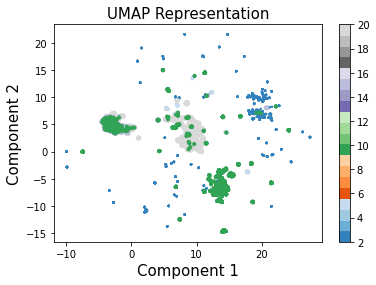

In [26]:
#We then graph, using col as the coloring key and hsv as the colormap (more colormaps here:
#https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html).
#scatter(u[:,0],u[:,1],s=5,c=col,cmap="hsv")
scatter(u[:,0],u[:,1],s=numCol,c=numCol,cmap="tab20c")
#scatter(u[:,0],u[:,1],s=2)
colorbar()
title("UMAP Representation",fontsize=15)
xlabel("Component 1",fontsize=15)
ylabel("Component 2",fontsize=15)
figsize(10,10)

In [27]:
#We can try also the plotnine package. For plotting there we need a pandas matrix. So we load pandas.
import pandas as pd
#We convert the u data frame, with the umap coordinates, to a dataframe.
df=pd.DataFrame(u,columns=["Coord1","Coord2"])
#We can add col as an additional column.
df['Database']=col

#It is also possible to generate new labellings with generateCol and add them.
newLab=generateCol(["Organism","BodyPart"],["Cow","Gut"],["all"])

df['Filtered_Classification']=newLab[0]
df['Filtered_Category']=newLab[1]
df['Filtered_Database']=newLab[2]

#We'll also generate a dataframe with only the samples which pass the filter selected.
SelectedDF=df[df["Filtered_Category"]!="Other"]

In [28]:
#Here we generate a list for changing the size of the dots.
sizeCol=[]

#We do a cycle through all samples. Those whose categories are not Other (in which case they have one of the categories,
#classifications, or database from the filter), have a size of 1. The rest have a size of 0.1.
for i in range(0,len(ids)):    
    if newLab[1][i]=="Other":
        sizeCol.append(0.5)
    else:
        sizeCol.append(1)
#We add the size info to the dataframe.
df['Size']=sizeCol

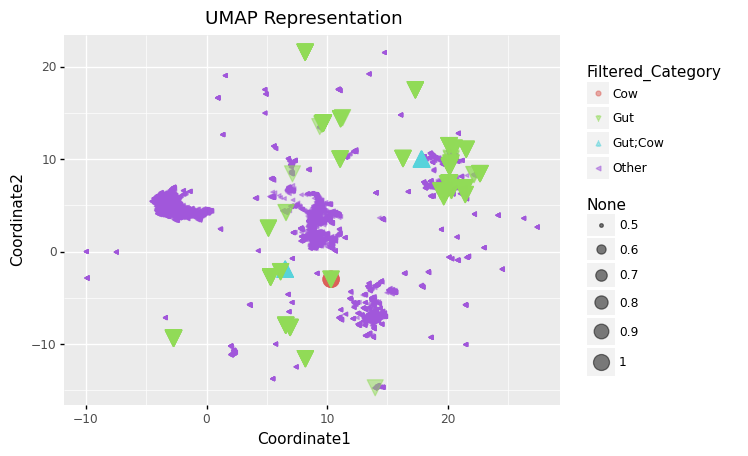

<ggplot: (108781073833)>

In [29]:
#We graph using plotnine.
from plotnine import *

(ggplot(df, aes(x='Coord1', y='Coord2', color='Filtered_Category', shape='Filtered_Category', size=sizeCol)) +
        geom_point(alpha = 0.5) + labs(title="UMAP Representation", x="Coordinate1", y="Coordinate2") + 
 scale_shape_manual(values=asarray(["o","v","^","<",">","1","2","3","4","8","s","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",1,2,3,4,"o","v","^"]))
)

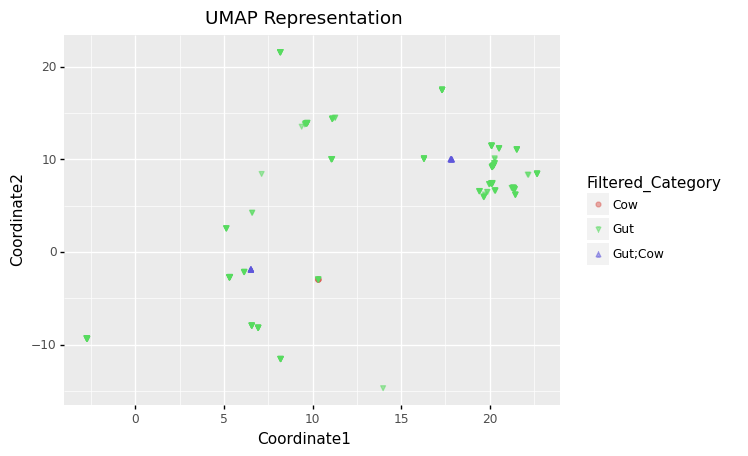

<ggplot: (108797935734)>

In [30]:
#Here, below, we graph only the samples that passed the filter. We do not alter sizes as it is not necessary.

(ggplot(SelectedDF, aes(x='Coord1', y='Coord2', color='Filtered_Category', shape='Filtered_Category')) +
        geom_point(alpha = 0.5) + labs(title="UMAP Representation", x="Coordinate1", y="Coordinate2") + 
 scale_shape_manual(values=asarray(["o","v","^","<",">","1","2","3","4","8","s","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",1,2,3,4,"o","v","^"]))
)

#### Inter vs Intra Category Distance Histogram

We can quickly graph a histogram of the distribution of distances of samples with the same category (intra category) or different category (inter category) to check how they behave.

In [27]:
#For that we go through newLab[1] (this can be changed to look at distances for classifications or databases. 
group_distances=[]
diff_distances=[]

#We cycle through the distances matrix. For each sample we do an internal cycle with the pairs of samples 
#(not considered yet) which include that sample. If they have the same category we save the distance
#in group_distances. Otherwise we save it in diff_distances.
for i in range(1,distances.shape[0]):
    for j in range(0,i):
        if newLab[1][i]==newLab[1][j]:
            group_distances.append(distances[i,j])
        else:
            diff_distances.append(distances[i,j])

In [41]:
from scipy.stats import ranksums,kstest

print(ranksums(group_distances,diff_distances))

print(kstest(group_distances,diff_distances))

RanksumsResult(statistic=-1789.1781879679966, pvalue=0.0)
KstestResult(statistic=0.3045883709819444, pvalue=0.0)


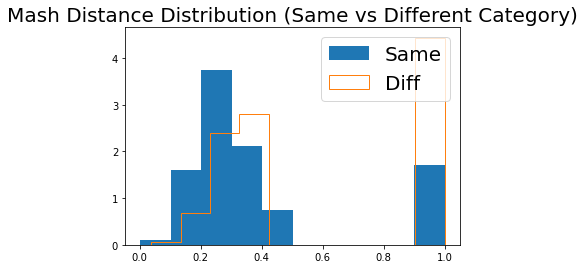

In [31]:
#Now we plot a histogram with the distribution of inter and intra distances.
hist(group_distances,histtype='bar',label="Same", density=True)
hist(diff_distances,histtype='step',label="Diff", density=True)
title("Mash Distance Distribution (Same vs Different Category)", fontsize=20)
legend(prop={'size': 20})
figsize(20,20)

### dbSCAN

In [26]:
#We can also try clustering algorithms and then visualize the clusters. If we want to visualize only some clusters,
#filterGroups can generate a coloring scheme in which only the indicated clusters (identified by their number)
#are shown and the rest have the same color number assigned. colList is the list of said clusters to be shown
#and OrigCol the original ordered list of cluster per sample.

#NOTE THAT THE SPATIAL DISPOSITION OF THE DOTS IN THE PLOTS IS STILL GIVEN BY UMAP. Here we're with DBSCAN we're 
#doing a clusterization, not a bidimensional representation of the distances, as umap does.
#no
def filterGroups(colList,OrigCol):
    NewCol=[]
    for i in OrigCol:
        if i in colList:
            NewCol.append(str(i))
        else:
            NewCol.append(str(-1))
    return NewCol


In [27]:
#First we try DBSCAN as a clustering mechanism. The parameters were tuned based on what's shown in the notebook
#Scatterplot-ClusteringTuning. Again we set the distance metric as precomputed.
from sklearn.cluster import DBSCAN
#dbg is the object resulting from the clusterization. dbg.labels_ is an ordered list with the cluster that each
#sample belongs to.
dbg=DBSCAN(eps=0.1,metric="precomputed",min_samples=10).fit(distances)

In [28]:
#For matplotlib it can be useful to set the cluster numbers as apart as possible so that the colormap gives them
#distinct colors. This is done here and the result is saved in dbscanCols.
dbscanCols=[]
for i in dbg.labels_:
    if i==-1:
        dbscanCols.append(0)
    elif i==0:
        dbscanCols.append(25*10)
    else:
        if (i+1)%2==0:
            dbscanCols.append((i+1)*10)
        else:
            dbscanCols.append((i+1)*-10)

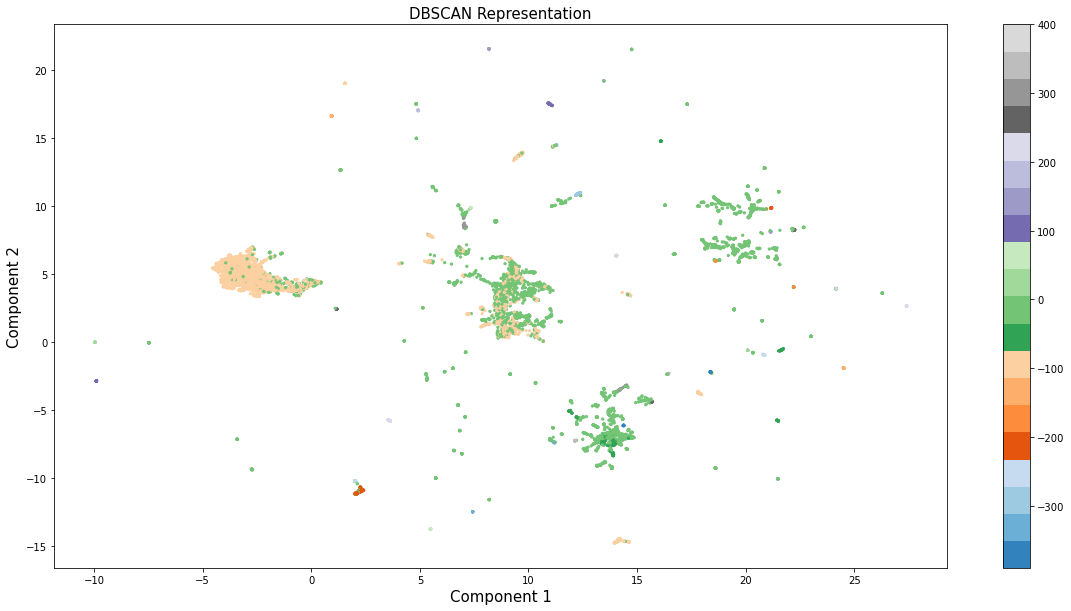

In [56]:
#We first plot using matplotlib, with dbscanCols as color scheme and tab20c as colormap.
scatter(u[:,0],u[:,1],s=5,c=dbscanCols,cmap="tab20c")
colorbar()
title("DBSCAN Representation",fontsize=15)
xlabel("Component 1",fontsize=15)
ylabel("Component 2",fontsize=15)
figsize(20,10)

In [29]:
#If we want to run DBSCAN with different parameters for plotnine it can be done here.
from sklearn.cluster import DBSCAN
dbg=DBSCAN(eps=0.1,metric="precomputed",min_samples=10).fit(distances)

In [30]:
#For plotnine we generate the pandas dataframe.
import pandas as pd

dfDBSC=pd.DataFrame(u,columns=["Coord1","Coord2"])
#We save the cluster number as a string so that coloring is done in a discrete fashion.
strLabels=[str(x) for x in list(dbg.labels_)]
#dfDBSC['Clusters']=dbg.labels_
dfDBSC['Clusters']=strLabels
#filterGroups can be used here if necessary to only see specific clusters.
#dfDBSC['Clusters']=filterGroups([2,3],dbg.labels_)

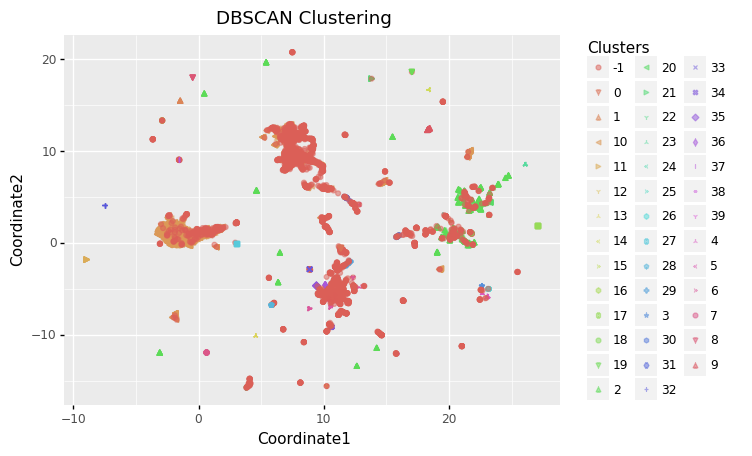

<ggplot: (163869814366)>

In [31]:
#Now we graph, same way as we did before.
from plotnine import *

(ggplot(dfDBSC, aes(x='Coord1', y='Coord2', color='Clusters', shape='Clusters')) +
        geom_point(alpha = 0.5) + labs(title="DBSCAN Clustering", x="Coordinate1", y="Coordinate2") + 
 scale_shape_manual(values=asarray(["o","v","^","<",">","1","2","3","4","8","s","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",1,2,3,4,"o","v","^"]))
)

# Category Enrichment in Clusters

Having clusters generated with either DBSCAN or HDBSCAN we can move on to check if there is enrichment or depletion of any specific category in the clusters (for now, regardless of the specific classification or level).

In [32]:
#First thing we need to do is generate a dictionary with all categories, regardless of level of classification, per
#sample.

#We can go over the sampletoHierarchy dictionaries and do this with every sample.

catPerSample={}

for sample in ids:
#For each sample we get the categories it is part of and add them to thisCatList.
    thisCatList=[]
    for classification in sampletoHierarchy[sample]:
#If there's no metadata in the sample we simply add No Metadata and that's it.}
        #if "Overall" in sampletoHierarchy[sample] and sampletoHierarchy[sample]["Overall"]=="No Metadata":
        #    thisCatList.append("No Metadata")
        #else:
        for category in sampletoHierarchy[sample][classification]:
            thisCatList.append(category)
#At the end we add thisCatList and the sample id as the value-key pair for catPerSample.
    catPerSample[sample]=thisCatList

In [33]:
#We will first count how many times each category is present amongst all samples. For that we go over all categories and
#count their abundance as we go.

CatAbundance={}

for classification in allHierarchy.keys():
#We get the categories from allHierarchy and count their abundance by looking in how many samples each category is
#present.
    for category in allHierarchy[classification].keys():
        abundance=0
        for sample,sampleCategories in catPerSample.items():
            if category in sampleCategories:
                abundance+=1
        CatAbundance[category]=abundance

In [34]:
#The next function, getSigTerms, will determine which terms are significantly enriched in each cluster. This will be
#done using binomial tests with a bonferroni correction. 
from scipy.stats import binom_test

#We need as parameter a list with the clusters, the categories per sample dictionary, the ids list, and the category
#abundance dictionary.
def getSigTerms(clusters,catSampleDict,IDList,catAbundanceDict):
#First thing we do is determine which samples are associated to each of the clusters. 
#First we get the number of clusters in total. We have to consider the 0-index in python and the fact that DBSCAN and
#HDBSCAN group all samples which were not confidently associated to a cluster in the -1 group (so this can be seen
#as a misc cluster).
    clustersPos=[]
#We sum a one whenever we make reference to a cluster as working with -1 as an index does not work (Python takes
#it as a reference to the last position). So for the purposes of the function cluster -1 will be treated as cluster
#0, cluster 0 as cluster 1, and so on.
    numClusters=max(clusters)-min(clusters)+1
    for i in range(numClusters):
        clustersPos.append([])
#We go through the list of cluster per sample. If the ith sample is associaed to the nth cluster, we save i in
#the nth list of clustersPos.
    for i in range(len(clusters)):
        clustersPos[(clusters[i]+1)].append(i)
#Now we move on to check which terms are present in each cluster .
    clust=0
    AllClusterTerms=[]
#We cycle through the clusters, look at the samples and add the categories associated to them to the pool of words in
#the sample (clusterTerms). We end up then with a list of lists with all the term for each cluster.
    while clust<=(max(clusters)+1):
        ClusterTerms=[]
        for member in clustersPos[clust]:
            sample=IDList[member]
            try:
#We make sure not to add No Metadata as a category and omit samples whose abundance in the cluster is 0.
                for category in catSampleDict[sample]:
                    if category not in ClusterTerms and category!="No Metadata" and catAbundanceDict[category]>0:
                        #print(category)
                        ClusterTerms.append(category)
            except: 
                pass
        AllClusterTerms.append(ClusterTerms)
        clust+=1

#We'll make as many binomial tests as there are terms present in each cluster. So we compute the number of 
#categories in total to be evaluated here.
    bonfCorrect=0
    for j in AllClusterTerms:
        bonfCorrect+=len(j)
    print(bonfCorrect)
#Now we do a final cycle through the list of lists with the categories per cluster to perform the binomial test.
    clust=0
    EnrichedAll={}
    SizeAll={}
    while clust<=(max(clusters)+1):
        #print(AllClusterTerms[clust])
#For each category per cluster, we determine how many samples are associated to that term, which yields the
#amount of time that the category occurs in the cluster.
        EnrichedThis=[]
        SizeThis={}
        for category in AllClusterTerms[clust]:
            #print(category)
            amount=0
            for sample in clustersPos[clust]:
                
                if category in catSampleDict[IDList[sample]]:
                    amount+=1
                    
#We then carry out a binomial test. The null hypothesis is that the fraction of samples that have the term inside the
#cluster is equal to the fraction of samples which have it in the overall dataset. To get the fraction in the 
#dataset we use the dictionary of CatAbundance.
            binomial=binom_test(x=amount, n=len(clustersPos[clust]),p=catAbundanceDict[category]/len(IDList))
#When we have the p-value we set 0.01 as the initial threshold of significance and perform the bonferroni correction.
            if binomial<0.01/(2*bonfCorrect):
#Categories which are significantly enriched (and also depleted) in a cluster are saved in the EnrichedThis list, and their
#abundance in the cluster in the SizeThis list.
                EnrichedThis.append(category)
                SizeThis[category]=amount
#After checking all categories in a cluster the lists generated just above are saved in dictionaries, which map cluster
#number (the original cluster numbers) to enriched/depleted categories and to their abundance. 
        realClust=clust-1
        EnrichedAll[realClust]=EnrichedThis
        SizeAll[realClust]=SizeThis
        clust+=1
    
    return EnrichedAll,SizeAll

In [35]:
#We run the function above for DBSCAN with categories and print the results.
enrichedKeywords,sizeKey=getSigTerms(dbg.labels_,catPerSample,ids,CatAbundance)

print("DBSCAN")
print("Cluster"+"\t"+"Category"+"\t"+"Abundance"+"\t"+"Cluster_Size"+"\t"+"Total Abundance")

clusters=max(dbg.labels_)-min(dbg.labels_)+1
for i in range(-1,clusters):
    Pos=i+1
    try:
#We use TotalTermAbundance to determine the total abundance in the dataset of the terms.
        for term in enrichedKeywords[i]:
            if sizeKey[i][term]==0:
                continue
            print(str(i)+"\t"+term+"\t"+str(sizeKey[i][term])+"\t"+str(list(dbg.labels_).count(i))+"\t"+str(CatAbundance[term])+"\n")
    except KeyError:
        pass

459
DBSCAN
Cluster	Category	Abundance	Cluster_Size	Total Abundance
-1	Environmental	2422	3224	5707

-1	Soil	405	3224	604

-1	Organismal	344	3224	1533

-1	Sediment	187	3224	245

-1	Seawater	128	3224	215

-1	Beach	33	3224	33

-1	Fecal	17	3224	151

-1	Rhizosphere	17	3224	111

-1	Peat	32	3224	33

-1	Shotgun	44	3224	452

-1	Human	62	3224	565

-1	Activated Sludge	52	3224	62

-1	Sludge	79	3224	94

-1	Oral-Caries	2	3224	46

-1	Fish	36	3224	40

-1	Kiosk	141	3224	221

-1	Metal	482	3224	800

-1	NYC	168	3224	1795

-1	Porto	50	3224	52

-1	Seat	196	3224	287

-1	Floor	46	3224	55

-1	London	258	3224	323

-1	Electronics	53	3224	58

-1	Doha	37	3224	41

-1	Oslo	41	3224	42

-1	Platform	33	3224	33

-1	Stockholm	56	3224	56

-1	Taipei	46	3224	47

-1	Nasopharynx	3	3224	57

-1	Oral-Gingival	1	3224	63

-1	Oral	1	3224	83

-1	Wood	9	3224	83

0	Lake	20	24	41

0	Lake Water	20	24	40

0	Metagenome	20	24	653

1	Fecal	12	12	151

1	Mice	12	12	78

1	Metagenome	12	12	653

1	Organismal	12	12	1533

2	Rhizosphere	77	721	111


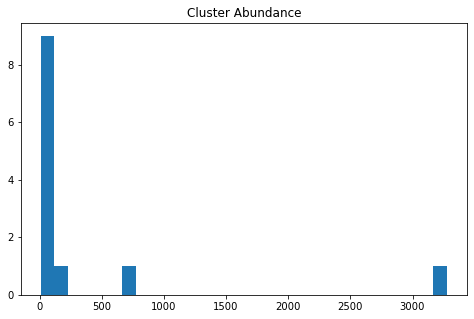

In [111]:
clusterAbundance=[]
for i in range(0,clusters):
    clusterAbundance.append(list(dbg.labels_).count(i))
    
hist(clusterAbundance,histtype='bar',label="Same", density=False,bins=30)
title("Cluster Abundance", fontsize=12)
figsize(8,5)

#### Selective Graphing of Clusters

In [36]:
#It might be useful to graph only certasin clusters. This can be done by modifying the original dataframe here (adding
#clusters to exclude in the isin list).
dfDBSCFiltered=dfDBSC[dfDBSC["Clusters"].isin(["-1"])==False]

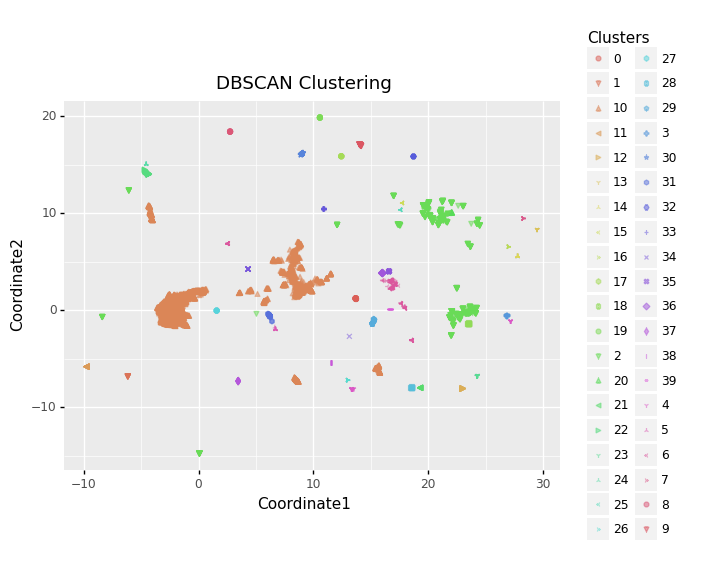

<ggplot: (133028632200)>

In [37]:
#Now we graph, same way as we did before.
from plotnine import *

(ggplot(dfDBSCFiltered, aes(x='Coord1', y='Coord2', color='Clusters', shape='Clusters')) +
        geom_point(alpha = 0.5) + labs(title="DBSCAN Clustering", x="Coordinate1", y="Coordinate2") + 
 scale_shape_manual(values=asarray(["o","v","^","<",">","1","2","3","4","8","s","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",1,2,3,4,"o","v","^"]))
)

#### Dataset Abundance per Cluster

In [38]:
#It also might be interesting to know the distribution of datasets per cluster. That is, how many samples in each 
#cluster come from each dataset. 

#We'll save the abundance per dataset in each cluster in dataserAbundance.
datasetAbundance={}

#Within each value we have another dictionary of the abundance per dataset.
for i in range(-1,max(dbg.labels_)+1):
    datasetAbundance[i]={"HMP":0,"MegaGenome":0,"TMDB":0,"PathoMAP":0,"MetaSUB":0}

#We cycle through all samples, determine the dataset of original based on their name and sum 1 to the dataset abundance of
#its cluster.
for i in range(0,len(dbg.labels_)):
    if "haib" in ids[i] or "sossowski" in ids[i]:
        datasetAbundance[dbg.labels_[i]]["MetaSUB"]+=1
    elif "HMP" in ids[i]:
        datasetAbundance[dbg.labels_[i]]["HMP"]+=1
    elif "PATHOMAP" in ids[i]:
        datasetAbundance[dbg.labels_[i]]["PathoMAP"]+=1
    elif "RR" in ids[i]:
        datasetAbundance[dbg.labels_[i]]["TMDB"]+=1
    else:
        datasetAbundance[dbg.labels_[i]]["MegaGenome"]+=1

In [39]:
#We print the normalized abundance of each dataset in each cluster.
print("Cluster"+"\t"+"HMP"+"\t"+"MetaSUB"+"\t"+"PathoMAP"+"\t"+"TMDB"+"\t"+"MegaGenome")

for cluster in datasetAbundance.keys():
    print(str(cluster)+"\t"+str(datasetAbundance[cluster]["HMP"]/list(dbg.labels_).count(cluster))+"\t"+str(datasetAbundance[cluster]["MetaSUB"]/list(dbg.labels_).count(cluster))+"\t"+str(datasetAbundance[cluster]["PathoMAP"]/list(dbg.labels_).count(cluster))+"\t"+str(datasetAbundance[cluster]["TMDB"]/list(dbg.labels_).count(cluster))+"\t"+str(datasetAbundance[cluster]["MegaGenome"]/list(dbg.labels_).count(cluster)))

Cluster	HMP	MetaSUB	PathoMAP	TMDB	MegaGenome
-1	0.013027295285359801	0.45564516129032256	0.016129032258064516	0.27233250620347393	0.24286600496277916
0	0.0	0.0	0.0	0.041666666666666664	0.9583333333333334
1	0.0	0.0	0.0	0.0	1.0
2	0.0	0.0	0.0	0.0013869625520110957	0.9986130374479889
3	0.0	0.0	0.0	0.0	1.0
4	0.0	0.0	0.0	0.0	1.0
5	0.0	0.0	0.0	0.0	1.0
6	0.0	0.0	0.0	0.6861702127659575	0.31382978723404253
7	0.0	0.0	0.0	0.0	1.0
8	0.0	0.0	0.0	0.0	1.0
9	0.0	0.0	0.0	0.0	1.0
10	0.09129770992366412	0.3242748091603053	0.4482442748091603	0.11389312977099236	0.022290076335877863
11	0.0	0.0	0.0	0.0	1.0
12	0.0	0.0	0.0	0.0	1.0
13	0.0	0.0	0.0	0.0	1.0
14	0.0	0.0	0.0	0.0	1.0
15	0.0	0.0	0.0	0.0	1.0
16	0.0	0.0	0.0	0.0	1.0
17	0.0	0.0	0.0	0.0	1.0
18	0.0	0.0	0.0	0.0	1.0
19	0.0	0.0	0.0	0.0	1.0
20	0.0	0.0	0.0	0.0	1.0
21	0.0	0.0	0.0	0.0	1.0
22	0.0	0.0	0.0	0.0	1.0
23	0.0	0.0	0.0	0.0	1.0
24	0.0	0.0	0.0	0.0	1.0
25	0.0	0.0	0.0	0.0	1.0
26	0.0	0.0	0.0	0.0	1.0
27	0.0	0.0	0.0	0.0	1.0
28	0.0	0.0	0.0	0.9166666666666666	0.08333

#### Reclustering and Enrichment on a Specific Cluster

In the case in which certain cluster is too big, it might be useful to cluster again on it through DBSCAN and check for enrichment in the clusters that are generated. We define a code here to do that. The code can be run for any cluster that is generated above.

In [36]:
#For reclustering we need to generate a new distance matrix, new dictionaries of categories per sample, and a new id
#list. We generate those using a function which takes the cluster number as parameters, as well as the cluster per 
#sample list generated by DBSCAN.

def extractClusterInfo(clusterNumber,clusters):
    #We go through the clusters list and get the positions of all samples withint the desired cluster. We save that in 
    #clusterPos. toDelete will save all samples that are not part of the cluster (we need this info for the cluster 
    #distance matrix).
    
    clusterPos=[]
    toDelete=[]
    
    for i in range(0,len(clusters)):
        if clusters[i]==clusterNumber:
            clusterPos.append(i)
        else:
            toDelete.append(i)
    
    #With the positions we move on to get the cluster IDs, and the categories per sample dictionary.
    clusterIDs=[]
    clusterCatPerSample={}
    
    #In both cases we go over ids and catPerSample (the complete dataset list) and get the info of the samples in the
    #clusters.
    for i in range(0,len(ids)):
        if i in clusterPos:
            clusterIDs.append(ids[i])
            
    for key,value in catPerSample.items():
        if key in clusterIDs:
            clusterCatPerSample[key]=value
    
    #Finally we get the cluster distances by removing those of the samples that are not present in the cluster.
    clusterDistances=np.delete(distances,toDelete,axis=0)
    clusterDistances=np.delete(clusterDistances,toDelete,axis=1)
    
    #We return the sample IDs, categories per sample, and cluster distances for the cluster.
    return clusterIDs,clusterCatPerSample,clusterDistances

In [84]:
#Now we run extractClusterInfo, and then umap and DBSCAN. DBSCAN parameters can be tweaked here if needed.
clusterInformation=extractClusterInfo(10,dbg.labels_)

clusterfit = umap.UMAP(n_components=2,metric="precomputed")
cu = fit.fit_transform(clusterInformation[2])

from sklearn.cluster import DBSCAN
cdbg=DBSCAN(eps=0.07,metric="precomputed",min_samples=10).fit(clusterInformation[2])

C:\Users\jlego\anaconda3\lib\site-packages\umap\umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data


In [85]:
#We can graph the results to have a reference.
import pandas as pd

dfDBSC=pd.DataFrame(cu,columns=["Coord1","Coord2"])
#We save the cluster number as a string so that coloring is done in a discrete fashion.
strLabels=[str(x) for x in list(cdbg.labels_)]
#dfDBSC['Clusters']=dbg.labels_
dfDBSC['Clusters']=strLabels
#filterGroups can be used here if necessary to only see specific clusters.
#dfDBSC['Clusters']=filterGroups([2,3],dbg.labels_)

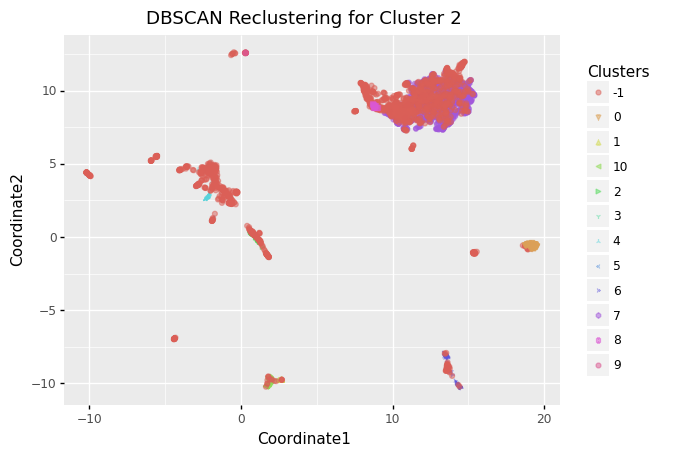

<ggplot: (163749293623)>

In [86]:
#Now we graph, same way as we did before.
from plotnine import *

(ggplot(dfDBSC, aes(x='Coord1', y='Coord2', color='Clusters', shape='Clusters')) +
        geom_point(alpha = 0.5) + labs(title="DBSCAN Reclustering for Cluster 2", x="Coordinate1", y="Coordinate2") + 
 scale_shape_manual(values=asarray(["o","v","^","<",">","1","2","3","4","8","s","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",1,2,3,4,"o","v","^"]))
)

In [87]:
#We need to define the total abundance per category but for only the categories within the cluster. We do that here.

clusterCatAbundance={}

for classification in allHierarchy.keys():
#We get the categories from allHierarchy and count their abundance by looking in how many cluster samples each category is
#present.
    for category in allHierarchy[classification].keys():
        abundance=0
        for sample,sampleCategories in clusterInformation[1].items():
            if category in sampleCategories:
                abundance+=1
        clusterCatAbundance[category]=abundance

In [88]:
#Now we run the enrichment for the new clusters.
enrichedKeywords,sizeKey=getSigTerms(cdbg.labels_,clusterInformation[1],clusterInformation[0],clusterCatAbundance)

print("DBSCAN")
print("Cluster"+"\t"+"Category"+"\t"+"Abundance"+"\t"+"Cluster_Size"+"\t"+"Total Abundance")

clusters=max(cdbg.labels_)-min(cdbg.labels_)+1
for i in range(-1,clusters):
    Pos=i+1
    try:
#We use TotalTermAbundance to determine the total abundance in the dataset of the terms.
        for term in enrichedKeywords[i]:
            if sizeKey[i][term]==0:
                continue
            print(str(i)+"\t"+term+"\t"+str(sizeKey[i][term])+"\t"+str(list(cdbg.labels_).count(i))+"\t"+str(clusterCatAbundance[term])+"\n")
    except KeyError:
        pass

153
DBSCAN
Cluster	Category	Abundance	Cluster_Size	Total Abundance
-1	Organismal	150	1669	434

-1	NYC	686	1669	1627

-1	Metal	267	1669	318

-1	Kiosk	73	1669	80

-1	Plastic	131	1669	175

-1	Seat	82	1669	91

-1	Handrail	90	1669	102

-1	Ilorin	58	1669	59

-1	Human	97	1669	319

-1	Shotgun	97	1669	299

-1	Oral-Gingival	4	1669	62

-1	Oral-Tongue	1	1669	46

-1	Forest	10	1669	68

0	Human	70	90	319

0	Organismal	90	90	434

0	Gut	20	90	20

0	Seawater	20	90	40

0	Metagenome	20	90	25

0	Mice	12	90	12

0	Fecal	50	90	77

0	Shotgun	50	90	299

1	Primate	14	14	20

1	Organismal	14	14	434

1	Seawater	14	14	40

2	NYC	5	43	1627

2	Tokyo	9	43	63

2	Berlin	4	43	7

3	London	10	32	65

3	NYC	3	32	1627

4	Metal	27	117	318

4	Stone	12	117	52

4	Pole	10	117	49

4	NYC	1	117	1627

4	Palm	21	117	74

4	Headboard	10	117	33

4	Door	13	117	40

5	Door	9	24	40

5	Headboard	6	24	33

5	Palm	6	24	74

6	Oral	35	143	70

6	Human	143	143	319

6	Shotgun	143	143	299

6	Organismal	143	143	434

6	Oral-Gingival	56	143	62

6	Oral-Tongu

## HMP only UMAP

As a side note here, we generate a graph for HMP only samples, and graph them based on the body part they're associtaed to. Note that these body parts are all values of the hierarchy, but some of them are merged into the same category. Here, we do not use the hierarchy but consider all possible body parts as distinct possible labelling options.

All the loading of distances and metadata and the graph are done below. This part of the code can be run independently from the rest.

In [1]:
%pylab inline 
import umap

Populating the interactive namespace from numpy and matplotlib


In [2]:
#We load the distance matrix, but now only for HMP data.
phy=open("MashTriangle/HMPDistances.phyllip","r")

#There are a total of 8220 samples for now (this can be seen in the first line of the phyllip file).
HMPdistances=np.zeros((450,450))
#We'll save the sample ids in a list and the distances in distances.
HMPids=[]

#We'll need a counter to fill the distance matrix.
i=-2
for line in phy:
#At the beggining of each line we increase the counter by 1.
    i+=1
#The first line of the file contains only the total number of samples so we ignore it (when we read the first line,
#i=-1).
    if i<0:
        continue
#The second line has just the id of the first samples. We simply save the id and that's it.
    if i==1:
        line=line.strip("\n").split("\t")
        HMPids.append(line[0].split(".gz")[0].split("/")[1])
        continue
    
#The rest of the lines have distances. In particular the nth id has n-1 distances (for the n-1 samples above it). 
#First we get the id.
    line=line.strip("\n").split("\t")
    HMPids.append(line[0].split(".gz")[0].split("/")[1])
    #continue
#Then we add the n-1 distances to the nth line and the nth column (the distance matrix is symmetrical).
    dist=asarray([float(x) for x in line[1::]])
    HMPdistances[0:i,i]=dist
    HMPdistances[i,0:i]=dist
    
phy.close()

In [3]:
#Now we load the metadata file as we did before, bur we keep the body part info as is, without hiearchy assignment.

hmpFile=open("ProjectMetadata/HMP_metadata.csv","r")
#bodyPart=list(np.zeros(967))
bodyPart={}
for line in hmpFile:
#We extract the lines we need. 
    line=line.strip("\n").split(",")
    HMPID=line[0].replace(" ","")
#If the sample doesn't have a mash distance we skip it.
    if HMPID not in HMPids:
        continue

#Position 1 of the metadata contains the type of sequencing, and 9 the body part.
    #bodyPart[HMPids.index(HMPID)]=str(line[9])
    bodyPart[HMPID]=line[9].lower()
hmpFile.close()

In [4]:
BPList=[]

for ID in HMPids:
    if ID in HMPids:
        BPList.append(bodyPart[ID])
    else:
        BPList.append("unknown")

In [5]:
#We run umap with the HMP distances.
fit = umap.UMAP(n_components=2,metric="precomputed")
u = fit.fit_transform(HMPdistances)

C:\Users\jlego\anaconda3\lib\site-packages\umap\umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [6]:
#Now we generate the pandas dataframe for plotnine.
import pandas as pd
#We convert the u data frame, with the umap coordinates, to a dataframe.
df=pd.DataFrame(u,columns=["Coord1","Coord2"])
#We can add col as an additional column.
df['BodyPart']=BPList

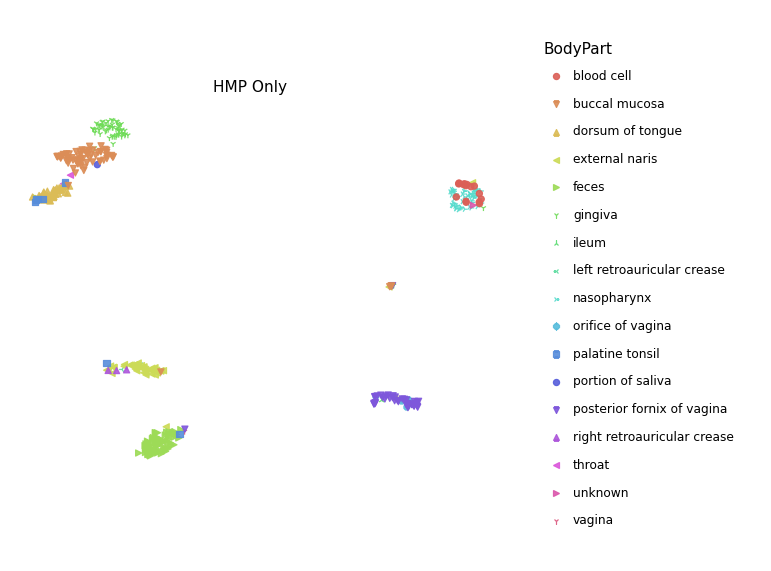

<ggplot: (94931239382)>

In [18]:
#And finally we graph.
from plotnine import *
#theme_set(theme_void())
(ggplot(df, aes(x='Coord1', y='Coord2', color='BodyPart', shape='BodyPart')) +
        geom_point(alpha = 0.9, size=2) + labs(title="HMP Only", x="Coordinate1", y="Coordinate2") + 
 scale_shape_manual(values=asarray(["o","v","^","<",">","1","2","3","4","8","s","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",1,2,3,4,"o","v","^"]))
)